In [ ]:
#no gpu
conda install pytorch torchvision torchaudio cpuonly -c pytorch

In [ ]:
#with gpu
conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia

# Imports

In [2]:
import os
import torch
import torchvision
import torchvision.transforms as t
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset, Dataset
import random 
from torchvision.io import read_image
import time

In [3]:
os.listdir("C:/Users/linh0/age_classification/data/age_range_dataset")

['.DS_Store',
 '0',
 '1',
 '10',
 '11',
 '12',
 '13',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

In [4]:
folder_names = [
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',]

# Data preparation

In [5]:
dataset_path = "C:/Users/linh0/age_classification/data/age_range_dataset"

In [6]:
torch.cuda.get_device_name()

'NVIDIA GeForce GTX 1060 with Max-Q Design'

In [7]:
def extract_age_from_folder(folder_name):
    age = int(folder_name)
    if 1 <= age <= 2:
        return 0
    elif 3 <= age <= 5:
        return 1
    elif 6 <= age <= 10:
        return 2
    elif 11 <= age <= 14:
        return 3
    elif 15 <= age <= 17:
        return 4
    elif 18 <= age <= 22:
        return 5
    elif 23 <= age <= 27:
        return 6
    elif 28 <= age <= 33:
        return 7
    elif 34 <= age <= 40:
        return 8
    elif 41 <= age <= 50:
        return 9
    elif 51 <= age <= 60:
        return 10
    elif 61 <= age <= 70:
        return 11
    elif 71 <= age <= 80:
        return 12
    else:
        return 13


In [8]:
get_mean_and_std(train_loader)

NameError: name 'get_mean_and_std' is not defined

In [9]:
mean = [ 0.0739, -0.0482, -0.1140]
std = [0.4999, 0.4792, 0.4785]

transform = t.Compose([
    t.Resize((224, 224)), 
    t.ToTensor(),
    t.Normalize(torch.Tensor(mean), torch.Tensor(std)) 
])

In [10]:
train_transform = t.Compose([
    t.Resize((224, 224)),
    t.RandomHorizontalFlip(),
    t.RandomRotation(degrees=10),
    t.ToTensor(),
    t.Normalize(torch.Tensor(mean), torch.Tensor(std)) 
])

In [11]:
dataset_path

'C:/Users/linh0/age_classification/data/age_range_dataset'

In [12]:
class transform_dataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        label = self.img_labels.iloc[idx, 1]
        age = int(label.split('_')[0])  # Extracting age from the label
        if self.transform:
            image = self.transform(image)
        return image, age

In [13]:
dataset = torchvision.datasets.ImageFolder(root=dataset_path,transform = transform)

In [14]:

labels = dataset.targets
train_indices, test_indices = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42, stratify = labels)

train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)
len(train_dataset)

19284

In [67]:

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


In [16]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        image, label = self.dataset[index]
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.dataset)

In [17]:
def get_mean_and_std(loader):
    mean = 0
    std = 0
    total_images_count = 0
    for images, _ in loader:
        image_count_in_a_batch = images.size(0)
        #print(images.shape)
        images = images.view(image_count_in_a_batch, images.size(1), -1)
        #print(images.shape)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += image_count_in_a_batch
        
    mean /= total_images_count
    std /= total_images_count
    
    return mean, std

# CUDA Support

In [18]:
def set_device():
    if torch.cuda.is_available():
        dev = "cuda"
    else:
        dev = "cpu"
    return torch.device(dev)

# Hyperparameter Tuning with cross validation

In [19]:
k_folds = 4
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)



In [20]:
epoch_range =  [1]

random_search_iterations = 1

# Old cross validation

In [44]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

def train_nn_hypertuning(model, train_dataset, criterion, epoch_range, random_search_iterations, class_names):
    best_model = None
    best_accuracy = 0
    best_recall = 0
    best_epoch = 0
    best_lr = 0
    best_wd = 0
    device = set_device()
    all_val_accuracies = []
    start_time = time.time()
    model.to(device)

    validation_results = []
    fold_confusion_matrices = []
    fold_precisions = []
    fold_recalls = []
    fold_f1s = []

    for iteration in range(random_search_iterations):
        num_epochs = epoch_range[iteration]

        print(f'Iteration {iteration + 1}/{random_search_iterations}, num_epochs: {num_epochs}')
        for lr in [0.001]:  #, 0.005, 0.0005, 0.00025]: 
            for wd in [0.001]:   #, 1e-4, 1e-5, 0.003]: 
                print(f'LR={lr}, WD={wd}')
                    
                optimizer = optim.SGD(model.parameters(), lr=lr,momentum = 0.9, weight_decay=wd)

                # K-Fold Cross-Validation
                for fold, (train_ids, val_ids) in enumerate(kfold.split(range(len(train_dataset)))):
                    # Print the fold number
                    fold_accuracy = []
                    print(f'Fold {fold + 1}')
                    #train_ids, val_ids = train_test_split(list(range(len(train_dataset))), test_size=0.2, random_state=42)
        
                    train_subsampler = Subset(train_dataset, train_ids)
                    val_subsampler = Subset(train_dataset, val_ids)
                    
                    # Assuming `train_transform` and `val_transform` are defined elsewhere
                    train_subsampler.dataset.transform = train_transform
                    val_subsampler.dataset.transform = transform
        
                    train_loader = DataLoader(train_subsampler, batch_size=16, shuffle=True)
                    val_loader = DataLoader(val_subsampler, batch_size=16, shuffle=False)
                    
                    small_grid_list = []
        
                    for epoch in range(num_epochs):
                        epoch_start_time = time.time() # start time for epoch
                        
                        model.train()
                        running_loss = 0.0
                        running_correct = 0.0
                        total = 0
                        all_labels = []
                        all_preds = []
                        # for i, (inputs, folder_names) in enumerate(train_loader):
                        #     inputs = inputs.to(device)
                        #     labels = [extract_age_from_folder(folder_name) for folder_name in folder_names]
                        #     labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1).to(device)
                        #     total += labels.size(0)
                        for data in train_loader:
                            inputs, labels = data
                            inputs = inputs.to(device)
                            labels = labels.to(device)
                            #labels = labels.view(labels.size(0), -1) 
                            total += labels.size(0)
                                    
                            optimizer.zero_grad()
                
                            # Forward pass
                            outputs = model(inputs)
                
                            _, predicted = torch.max(outputs.data, 1)
                            loss = criterion(outputs, labels)
                
                            # Backward pass and optimize
                            loss.backward()
                            optimizer.step()
                
                            running_loss += loss.item()
                            #predictions = outputs.argmax(dim=1, keepdim=True)
                            running_correct += (predicted == labels).sum().item()
                            all_labels.extend(labels.cpu().numpy())
                            all_preds.extend(predicted.cpu().numpy())
                
                        epoch_end_time = time.time()  # End timing for the epoch
                        epoch_elapsed_time = epoch_end_time - epoch_start_time  # Calculate elapsed time for the epoch

                        print(f"Epoch {epoch + 1}, Loss: {loss.item()}, Time: {epoch_elapsed_time:.2f} seconds")  # Display epoch time

                        epoch_loss = running_loss/len(train_loader)
                        epoch_acc = 100.00 * running_correct / total
                        
                        print("    - Training dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f"
                                 % (running_correct, total, epoch_acc, epoch_loss))
                        cm_train = confusion_matrix(all_labels, all_preds)
                        plt.figure(figsize=(10, 7))
                        sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
                        plt.xlabel('Predicted')
                        plt.ylabel('True')
                        plt.title('Training Confusion Matrix')
                        plt.show()
                        
                        # Compute precision, recall, and F1-score
                        precision_train = precision_score(all_labels, all_preds, average='weighted',zero_division=1)
                        recall_train = recall_score(all_labels, all_preds, average='weighted',zero_division=1)
                        f1_train = f1_score(all_labels, all_preds, average='weighted')
                        
                        print(f'Training Precision: {precision_train:.2f}')
                        print(f'Training Recall: {recall_train:.2f}')
                        print(f'Training F1 Score: {f1_train:.2f}')
                                
                        accuracy, cm, precision, recall, f1 = eval_model_test_set(model, val_loader, class_names)
                        fold_accuracies.append(accuracy)
                        fold_confusion_matrices.append(cm)
                        fold_precisions.append(precision)
                        fold_recalls.append(recall)
                        fold_f1s.append(f1)
                        fold_accuracy.append(accuracy)
                        if recall_train > best_recall:
                            best_recall = recall_train
                            best_epoch = num_epochs
                            best_model = model
                            best_lr = lr
                            best_wd = wd
                            save_checkpoint(model, epoch, optimizer, best_recall, lr, wd)
                        
                mean_acc = np.mean(fold_accuracy)
                mean_precision = np.mean(fold_precisions)
                mean_recall = np.mean(fold_recalls)
                mean_f1 = np.mean(fold_f1s)
                print(f'Validation Recall for fold {fold + 1}: {mean_recall}%')
    
                validation_results.append({'lr': lr, 'wd': wd, 'fold': fold + 1, 'recall': mean_recall})
            
                all_val_accuracies.append(mean_acc)
            
    end_time = time.time()  # End timing
    elapsed_time = end_time - start_time
    #print(f'Best number of epochs: {best_epoch}')
    print(f'Best lr: {best_lr}')
    print(f'Best wd: {best_wd}%')
    print(f'Best validation recall: {best_recall}%')
    print(f'Total training time: {elapsed_time // 60:.0f} minutes {elapsed_time % 60:.2f} seconds')

    # Plotting validation accuracy
    # plt.figure(figsize=(10, 5))
    # plt.plot(all_val_accuracies, range(1, len(all_val_accuracies) + 1), marker='o')
    # plt.xlabel('Validation Accuracy')
    # plt.ylabel('Iteration')
    # plt.title('Validation Accuracy per Iteration')
    # plt.show()

    plt.figure(figsize=(12, 6))
    for lr in [0.001, 0.005, 0.0005, 0.00025]:
        for wd in [0.001, 1e-4, 1e-5, 0.003]:
            accuracies = [result['recall'] for result in validation_results if result['lr'] == lr and result['wd'] == wd]
            plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', label=f'LR={lr}, WD={wd}')
    
    plt.xlabel('Fold')
    plt.ylabel('Validation Recall')
    plt.title('Validation Recall for Different LR and WD')
    plt.legend()
    plt.show()

    return best_lr, best_wd

# Helper method 

In [52]:
def train_epoch(model, train_loader, optimizer, criterion, device, lambda_l1):
    model.train()
    running_loss = 0.0
    running_correct = 0.0
    total = 0
    all_labels = []
    all_preds = []

    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        total += labels.size(0)
        optimizer.zero_grad()

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        
        l1_loss = l1_regularization(model, lambda_l1)
        total_loss = loss + l1_loss
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100.0 * running_correct / total
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return epoch_loss, epoch_acc, precision, recall, f1, all_labels, all_preds


In [22]:
def print_confusion_matrix_with_totals(cm, class_names):
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = cm.sum() - (fp + fn + tp)

    print(f'True Positives (TP): {tp.sum()}')
    print(f'False Positives (FP): {fp.sum()}')
    print(f'True Negatives (TN): {tn.sum()}')
    print(f'False Negatives (FN): {fn.sum()}')
    print(f'Total: {cm.sum()}')

    return tn, fp, fn, tp, tp + fp + tn + fn


In [23]:
import matplotlib.pyplot as plt

def plot_training_validation_error(training_errors, validation_errors, name, title):
    plt.figure(figsize=(6, 3))
    plt.plot(training_errors,'b-', label='Training Error')
    plt.plot(validation_errors,'r-', label='Validation Error')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig(name)
    plt.show()


In [24]:
def plot_training_validation(training_recalls, validation_recalls, name, title):
    plt.figure(figsize=(6, 3))
    plt.plot(training_recalls,'b-', label='Training')
    plt.plot(validation_recalls,'r-', label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig(name)
    plt.show()


In [25]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [26]:
def eval_model_test_set(model, val_loader, device, class_names, criterion):
    model.eval()
    all_labels = []
    all_preds = []
    epoch_start_time = time.time()
    total_loss = 0

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    epoch_end_time = time.time()
    epoch_elapsed_time = epoch_end_time - epoch_start_time
    total_loss = total_loss / len(val_loader)

    return cm, precision, recall, f1, epoch_elapsed_time, total_loss


In [53]:
import torch.nn.functional as F

def l1_regularization(model, lambda_l1):
    l1_loss = 0.0
    for param in model.parameters():
        l1_loss += torch.sum(torch.abs(param))
    return lambda_l1 * l1_loss


# Cross validation revisited 

In [45]:
def train_nn_hypertuning(model, train_dataset, criterion, epoch_range, random_search_iterations, class_names):
    best_model = None
    best_accuracy = 0
    best_recall = 0
    best_epoch = 0
    best_lr = 0
    best_wd = 0
    device = set_device()
    start_time = time.time()
    model.to(device)

    validation_results = []
    fold_precisions = []
    fold_recalls = []
    fold_f1s = []

    for iteration in range(random_search_iterations):
        num_epochs = epoch_range[iteration]
        print(f'Iteration {iteration + 1}/{random_search_iterations}, num_epochs: {num_epochs}')

        for lr in [0.001, 0.01, 0.005, 0.0005, 0.00025]:
            for wd in [0.001, 1e-4, 1e-5, 0.1]:
                print(f'LR={lr}, WD={wd}')
                optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=wd)

                for fold, (train_ids, val_ids) in enumerate(kfold.split(range(len(train_dataset)))):
                    print(f'Fold {fold + 1}')
                    train_subsampler = Subset(train_dataset, train_ids)
                    val_subsampler = Subset(train_dataset, val_ids)
                    train_subsampler.dataset.transform = train_transform
                    val_subsampler.dataset.transform = transform

                    train_loader = DataLoader(train_subsampler, batch_size=16, shuffle=True)
                    val_loader = DataLoader(val_subsampler, batch_size=16, shuffle=False)

                    for epoch in range(num_epochs):
                        epoch_start_time = time.time()

                        epoch_loss, epoch_acc, precision_train, recall_train, f1_train, all_labels, all_preds = \
                            train_epoch(model, train_loader, optimizer, criterion, device)

                        epoch_end_time = time.time()
                        epoch_elapsed_time = epoch_end_time - epoch_start_time
                        print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, Time: {epoch_elapsed_time:.2f} seconds")
                        print(f'Training Precision: {precision_train:.2f}, Recall: {recall_train:.2f}, F1 Score: {f1_train:.2f}')

                        cm_train = confusion_matrix(all_labels, all_preds)
                        #plot_confusion_matrix(cm_train, class_names, title='Training Confusion Matrix')
                        #print_confusion_matrix_with_totals(cm_train, class_names)

                        cm, precision, recall, f1, val_time, loss = eval_model_test_set(model, val_loader, device, class_names, criterion)
                        print(f'Validation Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}, Time: {val_time:.2f} seconds')
                        print(f'val loss: {loss:.4f}')
                        #plot_confusion_matrix(cm, class_names, title='Validation Confusion Matrix')
                        #print_confusion_matrix_with_totals(cm, class_names)
                        fold_precisions.append(precision)
                        fold_recalls.append(recall)
                        fold_f1s.append(f1)

                        if recall > best_recall:
                            best_recall = recall
                            best_epoch = num_epochs
                            best_model = model
                            best_lr = lr
                            best_wd = wd
                            save_checkpoint(model, epoch, optimizer, best_recall, lr, wd)
                        

                mean_recall = np.mean(fold_recalls)
                validation_results.append({'lr': lr, 'wd': wd, 'fold': fold + 1, 'recall': mean_recall})
                

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'Best lr: {best_lr}')
    print(f'Best wd: {best_wd}')
    print(f'Best validation recall: {best_recall}%')
    print(f'Total training time: {elapsed_time // 60:.0f} minutes {elapsed_time % 60:.2f} seconds')

    plt.figure(figsize=(12, 6))
    for lr in [0.001, 0.01, 0.005, 0.0005, 0.00025]:
        for wd in [0.001, 1e-4, 1e-5, 0.1]:
            recalls = [result['recall'] for result in validation_results if result['lr'] == lr and result['wd'] == wd]
            plt.plot(range(1, len(recalls) + 1), recalls, marker='o', label=f'LR={lr}, WD={wd}')
    
    plt.xlabel('Fold')
    plt.ylabel('Validation Recall')
    plt.title('Validation Recall for Different LR and WD')
    plt.legend()
    plt.show()
    plt.savefig('tuning.png')

    return best_model, best_lr, best_wd


# Training method

In [54]:
def train_nn(model, train_loader, test_loader,criterion, optimizer, n_epochs, patience, class_names, lambda_l1):
    device = set_device()
    best_acc = 0
    best_recall = 0
    best_epoch = 0
    patience_count = 0
    model.to(device)
    train_recall = []
    val_recall = []
    train_error = []
    val_error = []
    train_precision = []
    val_precision = []
    train_error_precision = []
    val_error_precision = []
    
    total = 0
    start_time = time.time()
    for epoch in range(n_epochs):
        epoch_start_time = time.time()

        epoch_loss, epoch_acc, precision_train, recall_train, f1_train, all_labels, all_preds = \
                    train_epoch(model, train_loader, optimizer, criterion, device, lambda_l1)

        epoch_end_time = time.time()
        epoch_elapsed_time = epoch_end_time - epoch_start_time
        print("[===============================================================================================================================================================]")
        print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, Time: {epoch_elapsed_time // 60:.0f} minutes {epoch_elapsed_time % 60:.2f} seconds")
        print(f'Training Precision: {precision_train:.2f}, Recall: {recall_train:.2f}, F1 Score: {f1_train:.2f}')
        train_recall.append(recall_train)
        train_error.append(1-recall_train)
        train_precision.append(precision_train)
        train_error_precision.append(1-precision_train)
        print("[===============================================================================================================================================================]")
        

        cm_train = confusion_matrix(all_labels, all_preds)
        #plot_confusion_matrix(cm_train, class_names, title='Training Confusion Matrix')
        #print_confusion_matrix_with_totals(cm_train, class_names)

        cm, precision, recall, f1, val_time, loss = eval_model_test_set(model, test_loader, device, class_names, criterion)
        print(f'Validation Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}, Time: {val_time // 60:.0f} minutes {val_time % 60:.2f} seconds')
        print(f'Val Loss: {loss:.4f}')
        #plot_confusion_matrix(cm, class_names, title='Validation Confusion Matrix')
        #print_confusion_matrix_with_totals(cm, class_names)
        val_recall.append(recall)
        val_error.append(1-recall)
        val_precision.append(precision)
        val_error_precision.append(1-precision)

        if recall > best_recall:
            best_recall = recall
            best_epoch = epoch+1
            best_model = model
            patience_count = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_count += 1
            if patience_count >= patience:
                print(f'Recall did not improve for {patience} epochs. Early stopping...')
                break
    print("[===============================================================================================================================================================]")

    end_time = time.time()  # End timing
    elapsed_time = end_time - start_time
    print(f'Total training time: {elapsed_time // 60:.0f} minutes {elapsed_time % 60:.2f} seconds')
    print(f'Best Validation Recall: {best_recall} at Epoch {best_epoch}')
    plot_training_validation_error(train_error, val_error, "Recall Error", "Training and Validation Recall Error")
    plot_training_validation(train_recall, val_recall, "Recall", "Training and Validation Recall")
    plot_training_validation_error(train_error_precision, val_error_precision, "Precision Error", "Training and Validation Precision Error")
    plot_training_validation(train_precision, val_precision, "Precision", "Training and Validation Precision")
        
    return best_model

In [29]:
def save_checkpoint( model, epoch, optimizer, best_recall, lr, wd):
    state = {
        'epoch': epoch +1,
        'model': model.state_dict(),
        'lr': lr,
        'wd': wd,
        'best_recall': best_recall,
        'optimizer' : optimizer.state_dict(),
    }
    torch.save(state, 'model_best_checkpoint.pth.tar')

# All experimented model

In [48]:
class AgeModel(nn.Module):
    def __init__(self, num_classes):
        super(AgeModel, self).__init__()
        self.model = models.resnet50(weights='IMAGENET1K_V2')
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)
        self.model.fc = nn.Sequential(nn.Dropout(p=0.5, inplace=True),
                                          nn.Linear(in_features=2048, out_features=256, bias=True),
                                          nn.Linear(in_features=256, out_features=14, bias=True))
        device = set_device()
        self.model = self.model.to(device)
    def forward(self, x):
        x = self.model(x)
        return x
        

In [31]:
import torch.nn as nn
import torchvision.models as models

class AgeModelv2(nn.Module):
    def __init__(self, num_classes):
        super(AgeModelv2, self).__init__()
        self.model = models.resnet50(weights='IMAGENET1K_V2')
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),  
            nn.Linear(256, num_classes) 
        )
        device = set_device()
        self.model = self.model.to(device)
        
    def forward(self, x):
        x = self.model(x)
        return x


In [32]:
import torch
import torch.nn as nn
import torchvision.models as models

class AgeModelv3(nn.Module):
    def __init__(self, num_classes=14):
        super(AgeModelv3, self).__init__()
        self.resnet50 = models.resnet50(weights='IMAGENET1K_V2')
        
        num_ftrs = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Identity()  
        
        self.custom_layers = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.resnet50(x)
        x = self.custom_layers(x)
        return x

# Hyperparameter tuning with 1 epochs each and 4 fold lr = [0.001, 0.01, 0.005, 0.0005, 0.00025] and wd = [0.001, 1e-4, 1e-5, 0.1]

In [41]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torchvision.models import ResNet50_Weights, efficientnet_b0, EfficientNet_B0_Weights


num_of_classes = 14
model = AgeModel(num_of_classes)
device = set_device()
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()

Iteration 1/1, num_epochs: 1
LR=0.001, WD=0.001
Fold 1
Epoch 1, Loss: 1.8864, Accuracy: 32.85%, Time: 429.32 seconds
Training Precision: 0.33, Recall: 0.33, F1 Score: 0.27
Validation Precision: 0.43, Recall: 0.43, F1 Score: 0.37, Time: 103.77 seconds
Fold 2
Epoch 1, Loss: 1.4744, Accuracy: 43.05%, Time: 573.85 seconds
Training Precision: 0.40, Recall: 0.43, F1 Score: 0.39
Validation Precision: 0.42, Recall: 0.44, F1 Score: 0.39, Time: 98.78 seconds
Fold 3
Epoch 1, Loss: 1.3463, Accuracy: 46.41%, Time: 531.34 seconds
Training Precision: 0.45, Recall: 0.46, F1 Score: 0.44
Validation Precision: 0.49, Recall: 0.50, F1 Score: 0.47, Time: 99.84 seconds
Fold 4
Epoch 1, Loss: 1.2397, Accuracy: 50.27%, Time: 528.90 seconds
Training Precision: 0.49, Recall: 0.50, F1 Score: 0.48
Validation Precision: 0.52, Recall: 0.53, F1 Score: 0.52, Time: 87.88 seconds
LR=0.001, WD=0.0001
Fold 1
Epoch 1, Loss: 1.1294, Accuracy: 53.43%, Time: 548.24 seconds
Training Precision: 0.52, Recall: 0.53, F1 Score: 0.52

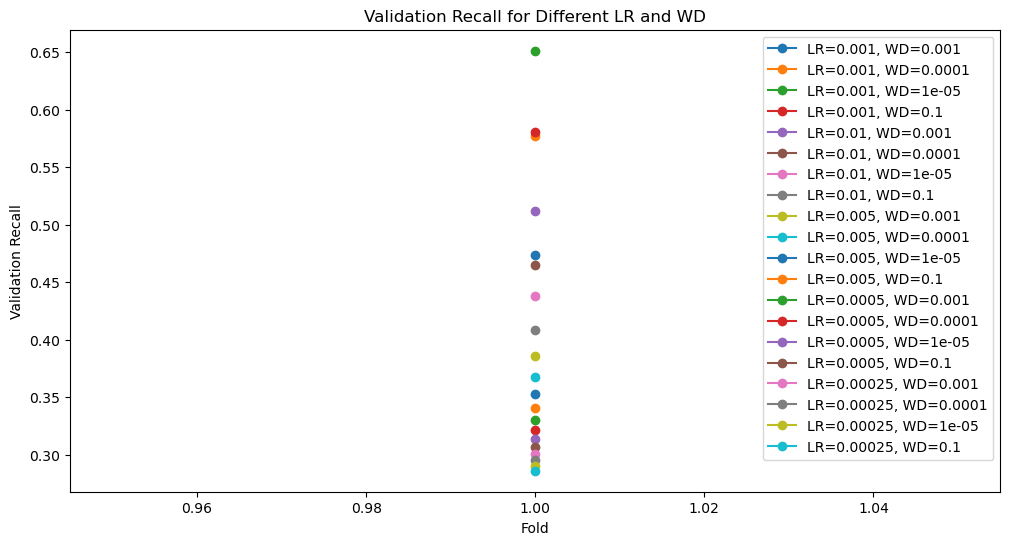

<Figure size 640x480 with 0 Axes>

In [66]:
model, lr, wd = train_nn_hypertuning(model, train_dataset, loss_fn, epoch_range, random_search_iterations, folder_names)

In [37]:
checkpoint = torch.load('model_best_checkpoint.pth.tar')

# Data for training

In [82]:
labels_train = [labels[i] for i in train_dataset.indices] #extracting labels to stratify the validation set
train_nn_indices, val_indices = train_test_split(list(range(len(train_dataset))), test_size=0.25, random_state=42, stratify = labels_train)

In [119]:
train_nn_dataset = Subset(train_dataset, train_nn_indices)
val_dataset = Subset(train_dataset, val_indices)

train_nn_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = transform

train_nn_loader = DataLoader(train_nn_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# First training with 50 epochs and early stop loss patience 7, drop out rate 0.2, AgeModel v1

In [39]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torchvision.models import ResNet50_Weights


num_of_classes = 14
model = AgeModel(num_of_classes)



lr: 0.001, wd: 1e-05
[===============================================================================================================================================================]
Epoch 1, Loss: 1.4246, Accuracy: 43.92%, Time: 10 minutes 7.89 seconds
Training Precision: 0.41, Recall: 0.44, F1 Score: 0.41
[===============================================================================================================================================================]
Validation Precision: 0.44, Recall: 0.46, F1 Score: 0.41, Time: 36 minutes 35.96 seconds
[===============================================================================================================================================================]
Epoch 2, Loss: 1.2523, Accuracy: 49.38%, Time: 11 minutes 49.49 seconds
Training Precision: 0.48, Recall: 0.49, F1 Score: 0.47
[======================================================================================================================================================

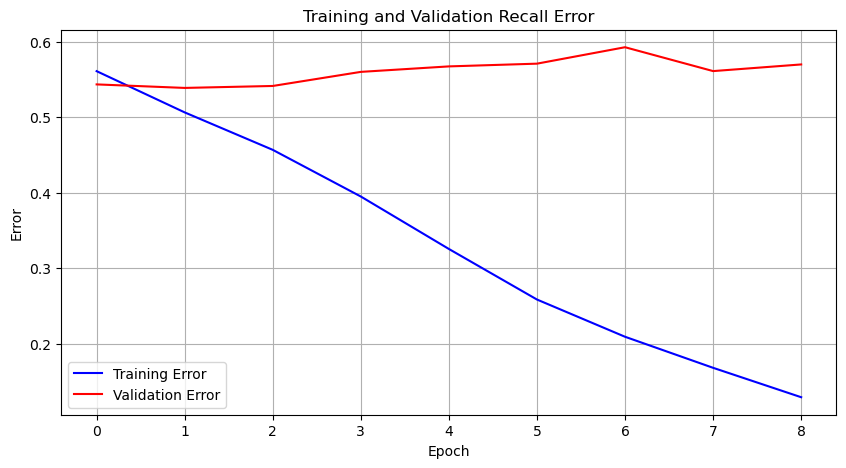

<Figure size 640x480 with 0 Axes>

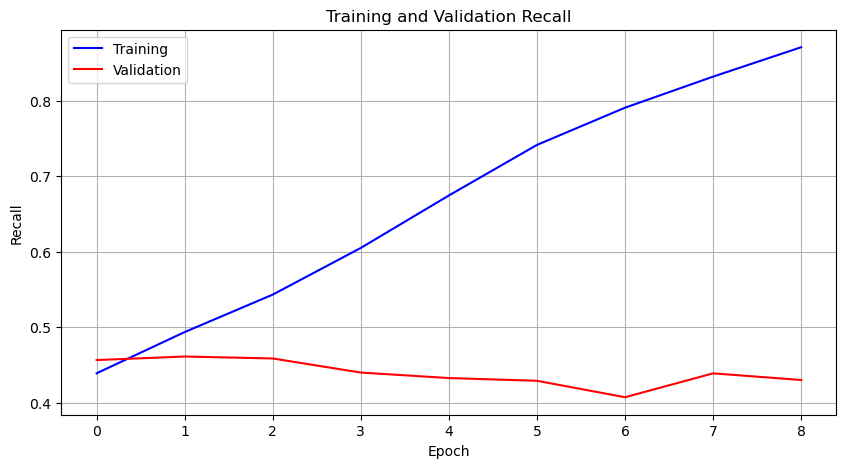

<Figure size 640x480 with 0 Axes>

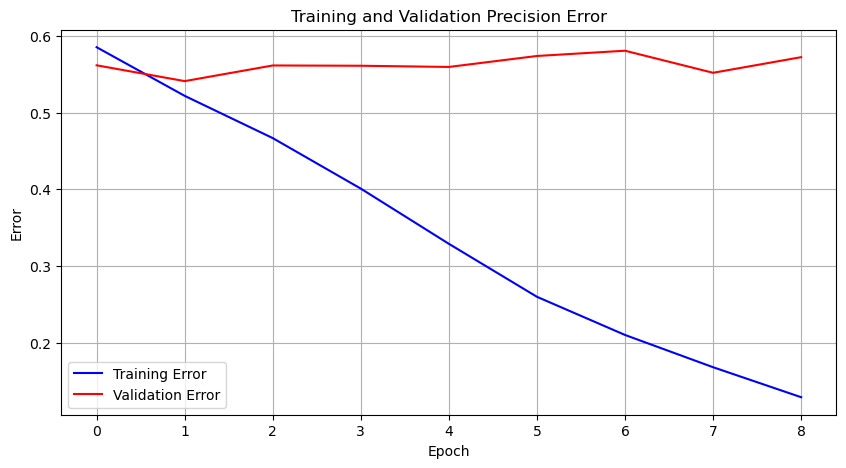

<Figure size 640x480 with 0 Axes>

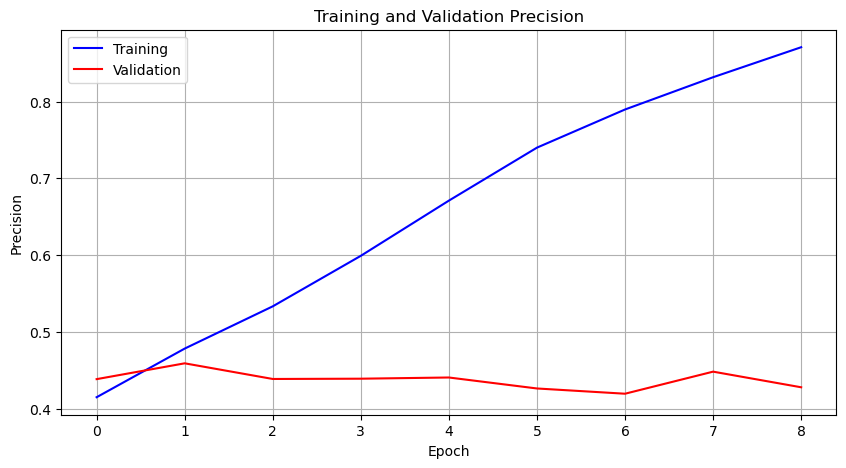

<Figure size 640x480 with 0 Axes>

In [86]:

lr = checkpoint['lr']
wd = checkpoint['wd']
print(f'lr: {lr}, wd: {wd}')
optimizer = optim.SGD(model.parameters(), lr=lr, momentum = 0.9, weight_decay=wd)
best_model = train_nn(model, train_nn_loader, val_loader, loss_fn, optimizer, 50, 7, folder_names)
torch.save(best_model, 'best_model.pth')

# Second training with drop out rate 0.4 now added stratify fo the dataset

lr: 0.001, wd: 1e-05
[===============================================================================================================================================================]
Epoch 1, Loss: 0.9952, Accuracy: 64.85%, Time: 9 minutes 25.59 seconds
Training Precision: 0.65, Recall: 0.65, F1 Score: 0.64
[===============================================================================================================================================================]
Validation Precision: 0.61, Recall: 0.61, F1 Score: 0.61, Time: 1 minutes 14.75 seconds
Val Loss: 1.0773
[===============================================================================================================================================================]
Epoch 2, Loss: 0.7059, Accuracy: 73.73%, Time: 10 minutes 45.64 seconds
Training Precision: 0.74, Recall: 0.74, F1 Score: 0.74
[======================================================================================================================================

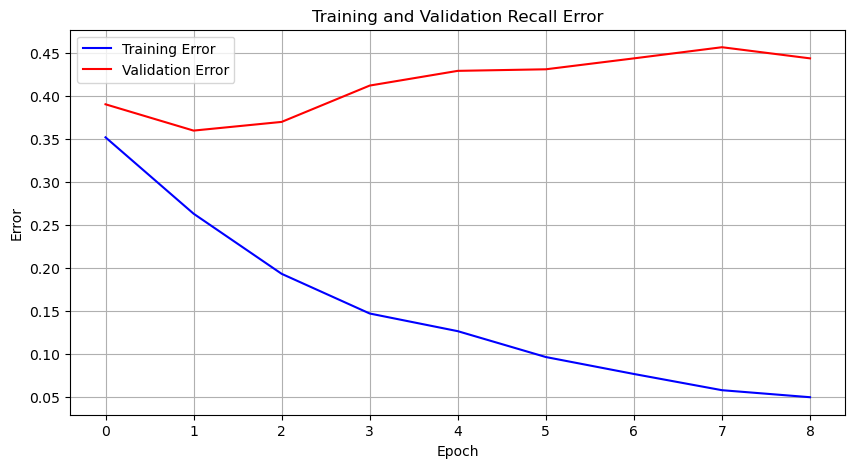

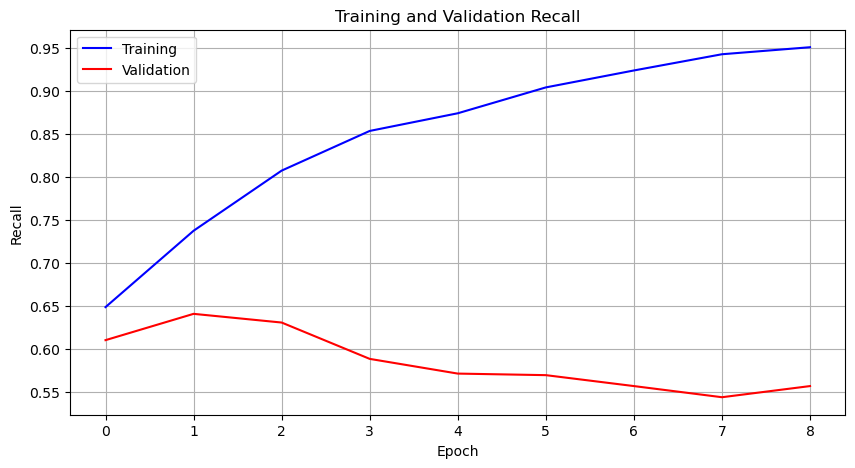

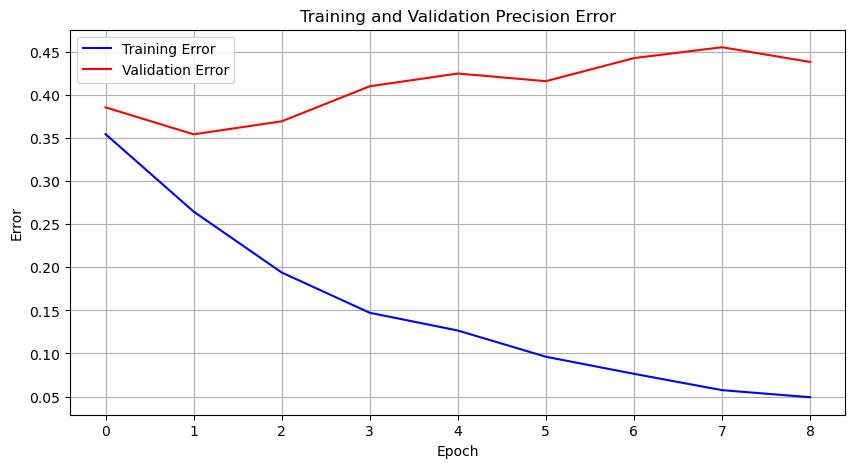

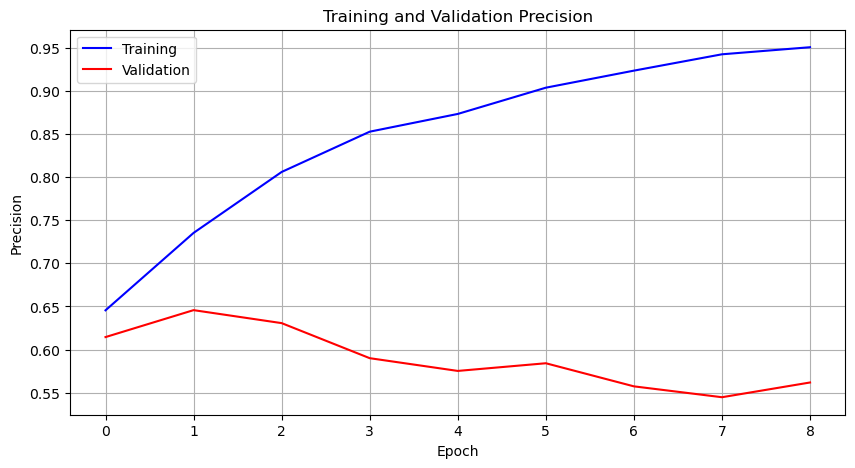

In [130]:
lr = checkpoint['lr']
wd = checkpoint['wd']
print(f'lr: {lr}, wd: {wd}')
optimizer = optim.SGD(model.parameters(), lr=lr, momentum = 0.9, weight_decay=wd)
best_model = train_nn(model, train_nn_loader, val_loader, loss_fn, optimizer, 50, 7, folder_names)
torch.save(best_model.state_dict(), 'best_model.pth')

# Third training: AgeModelv2 

lr: 0.001, wd: 1e-05
[===============================================================================================================================================================]
Epoch 1, Loss: 2.0508, Accuracy: 28.40%, Time: 9 minutes 12.74 seconds
Training Precision: 0.30, Recall: 0.28, F1 Score: 0.21
[===============================================================================================================================================================]
Validation Precision: 0.44, Recall: 0.38, F1 Score: 0.32, Time: 1 minutes 17.28 seconds
Val Loss: 1.6373
[===============================================================================================================================================================]
Epoch 2, Loss: 1.5450, Accuracy: 40.11%, Time: 11 minutes 53.22 seconds
Training Precision: 0.37, Recall: 0.40, F1 Score: 0.36
[======================================================================================================================================

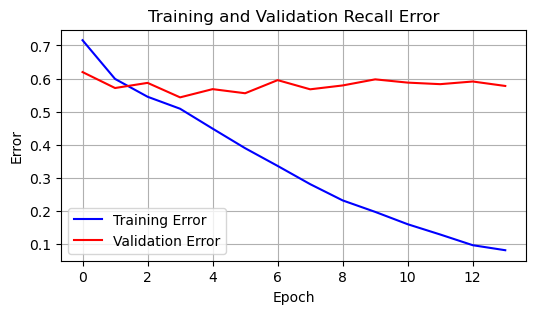

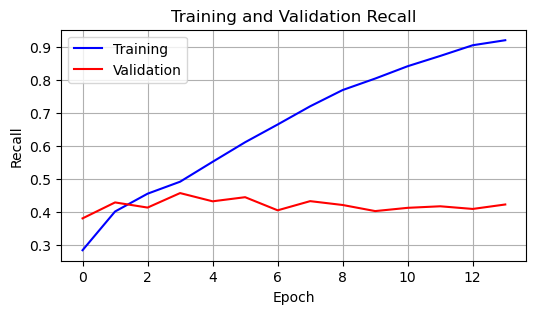

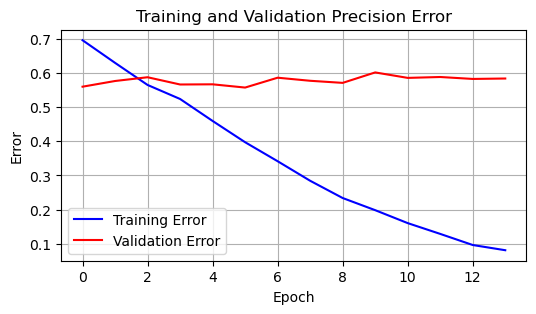

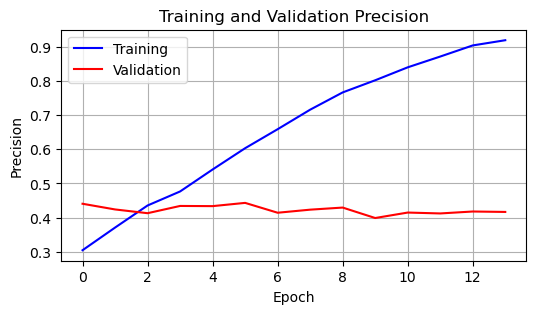

In [47]:
num_of_classes = 14
model = AgeModelv2(num_of_classes)

lr = checkpoint['lr']
wd = checkpoint['wd']
print(f'lr: {lr}, wd: {wd}')
optimizer = optim.SGD(model.parameters(), lr=lr, momentum = 0.9, weight_decay=wd)
best_model = train_nn(model, train_nn_loader, val_loader, loss_fn, optimizer, 50, 10, folder_names)
torch.save(best_model.state_dict(), 'best_model.pth')

# Fourth Training AgeModel with drop out rate 0.5

In [60]:
num_of_classes = 14
model = AgeModel(num_of_classes)
model.load_state_dict(checkpoint['model'])


<All keys matched successfully>

lr: 0.001, wd: 1e-05
[===============================================================================================================================================================]
Epoch 1, Loss: 0.7662, Accuracy: 73.86%, Time: 7 minutes 27.98 seconds
Training Precision: 0.74, Recall: 0.74, F1 Score: 0.74
[===============================================================================================================================================================]
Validation Precision: 0.77, Recall: 0.76, F1 Score: 0.76, Time: 1 minutes 4.08 seconds
Val Loss: 0.6872
[===============================================================================================================================================================]
Epoch 2, Loss: 0.4806, Accuracy: 83.17%, Time: 8 minutes 41.57 seconds
Training Precision: 0.83, Recall: 0.83, F1 Score: 0.83
[========================================================================================================================================

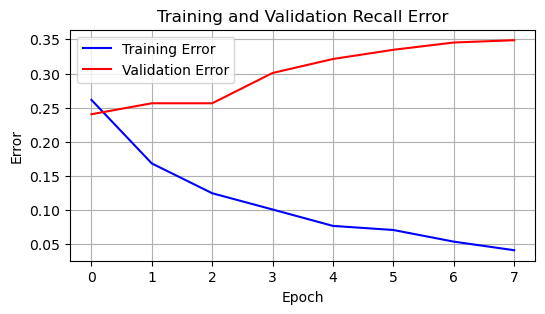

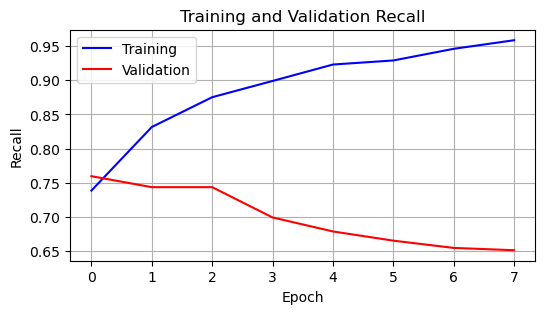

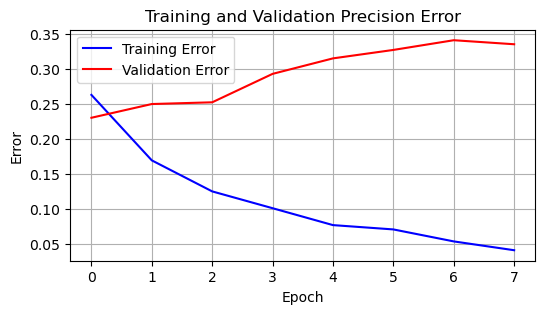

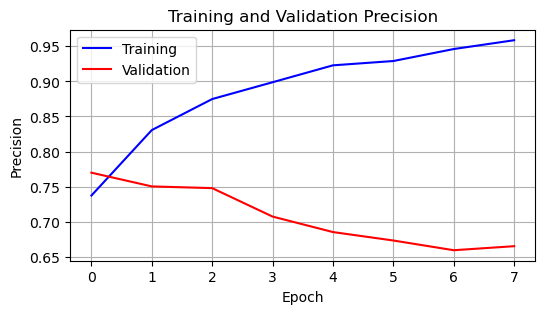

In [50]:
lr = checkpoint['lr']
wd = checkpoint['wd']
print(f'lr: {lr}, wd: {wd}')
optimizer = optim.SGD(model.parameters(), lr=lr, momentum = 0.9, weight_decay=wd)
best_model = train_nn(model, train_nn_loader, val_loader, loss_fn, optimizer, 50, 7, folder_names)
torch.save(best_model, 'best_model.pth')

# Fifth training with L1 Regularlization with lambda at 0.08

lr: 0.001, wd: 1e-05
[===============================================================================================================================================================]
Epoch 1, Loss: 0.7314, Accuracy: 75.04%, Time: 9 minutes 22.95 seconds
Training Precision: 0.75, Recall: 0.75, F1 Score: 0.75
[===============================================================================================================================================================]
Validation Precision: 0.77, Recall: 0.76, F1 Score: 0.76, Time: 1 minutes 9.49 seconds
Val Loss: 0.7039
[===============================================================================================================================================================]
Epoch 2, Loss: 0.4568, Accuracy: 84.02%, Time: 10 minutes 42.79 seconds
Training Precision: 0.84, Recall: 0.84, F1 Score: 0.84
[=======================================================================================================================================

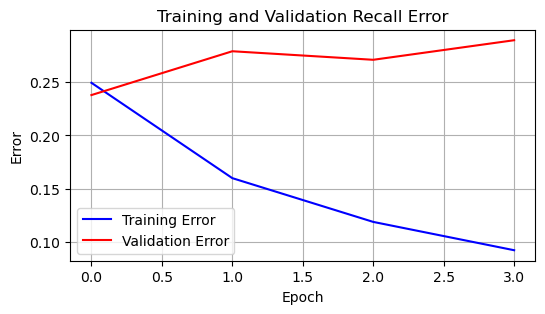

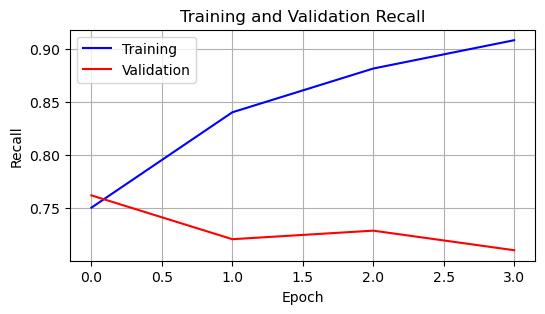

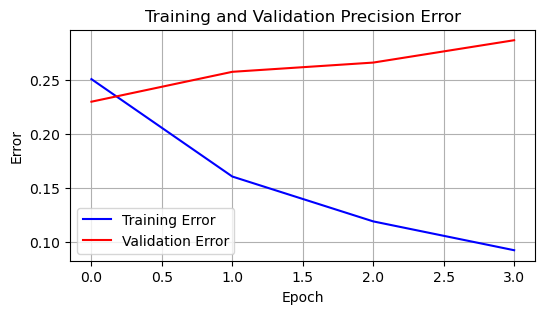

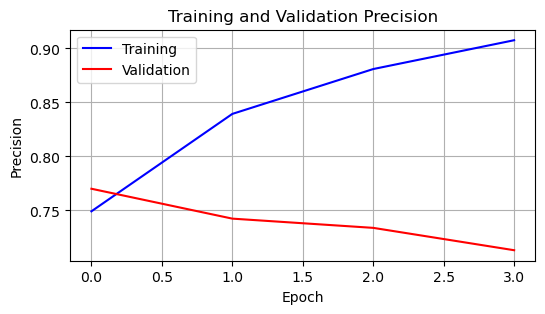

In [58]:
lambda_l1 = 0.08
lr = checkpoint['lr']
wd = checkpoint['wd']
print(f'lr: {lr}, wd: {wd}')
optimizer = optim.SGD(model.parameters(), lr=lr, momentum = 0.9, weight_decay=wd)
best_model = train_nn(model, train_nn_loader, val_loader, loss_fn, optimizer, 50, 3, folder_names, lambda_l1)
torch.save(best_model, 'best_model.pth')

# Sixth training with wd = 1e-6 and lambda 0.1 with new validation set to be 0.15 of the training set with batch size 4 (orginally 16)

lr: 0.001, wd: 1e-06
[===============================================================================================================================================================]
Epoch 1, Loss: 1.8139, Accuracy: 33.45%, Time: 17 minutes 48.53 seconds
Training Precision: 0.30, Recall: 0.33, F1 Score: 0.29
[===============================================================================================================================================================]
Validation Precision: 0.39, Recall: 0.42, F1 Score: 0.35, Time: 1 minutes 12.76 seconds
Val Loss: 1.5256
[===============================================================================================================================================================]
Epoch 2, Loss: 1.5083, Accuracy: 41.35%, Time: 20 minutes 24.71 seconds
Training Precision: 0.39, Recall: 0.41, F1 Score: 0.38
[=====================================================================================================================================

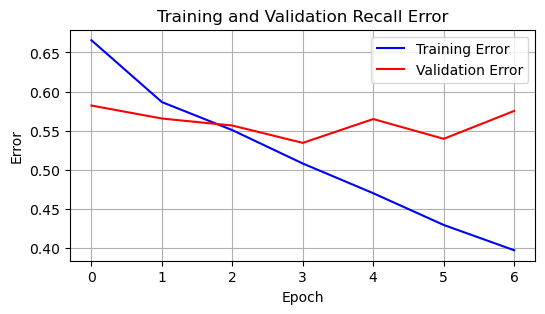

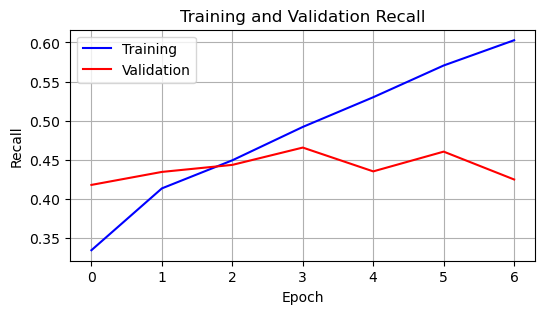

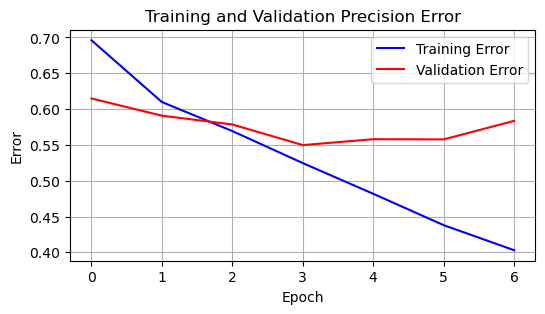

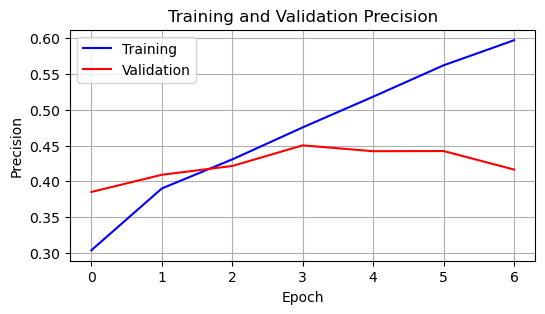

In [69]:
num_of_classes = 14
model = AgeModel(num_of_classes)
lambda_l1 = 0.1
lr = checkpoint['lr']
wd = 1e-6
print(f'lr: {lr}, wd: {wd}')
optimizer = optim.SGD(model.parameters(), lr=lr, momentum = 0.9, weight_decay=wd)
best_model = train_nn(model, train_nn_loader, val_loader, loss_fn, optimizer, 50, 3, folder_names, lambda_l1)
torch.save(best_model, 'best_model.pth')

# Seventh Training batch size 8 back to lambda 0.09 and wd 1e-6

In [72]:
num_of_classes = 14
model = AgeModel(num_of_classes)
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

lr: 0.001, wd: 1e-06
[===============================================================================================================================================================]
Epoch 1, Loss: 1.0863, Accuracy: 59.51%, Time: 11 minutes 48.00 seconds
Training Precision: 0.59, Recall: 0.60, F1 Score: 0.59
[===============================================================================================================================================================]
Validation Precision: 0.62, Recall: 0.60, F1 Score: 0.59, Time: 1 minutes 1.02 seconds
Val Loss: 1.0518
[===============================================================================================================================================================]
Epoch 2, Loss: 0.8912, Accuracy: 65.94%, Time: 14 minutes 5.58 seconds
Training Precision: 0.66, Recall: 0.66, F1 Score: 0.66
[=======================================================================================================================================

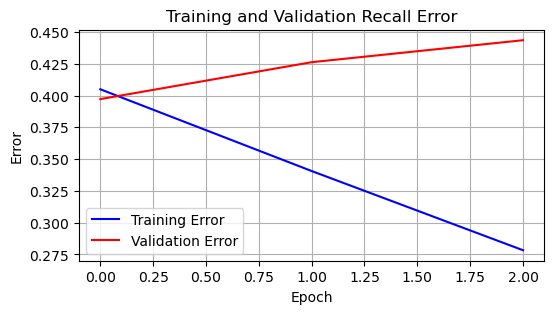

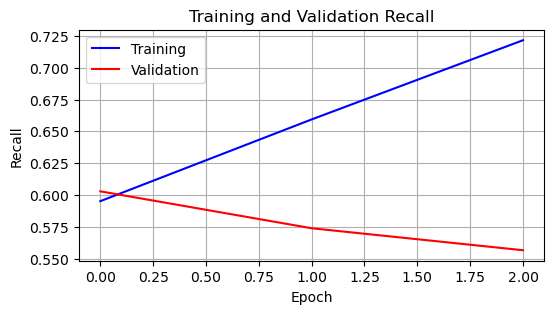

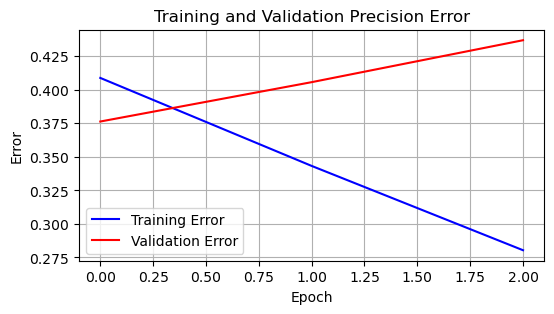

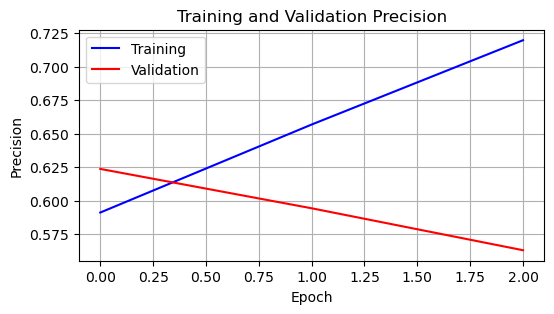

In [74]:
lambda_l1 = 0.08
lr = checkpoint['lr']
wd = 1e-6
print(f'lr: {lr}, wd: {wd}')
optimizer = optim.SGD(model.parameters(), lr=lr, momentum = 0.9, weight_decay=wd)
best_model = train_nn(model, train_nn_loader, val_loader, loss_fn, optimizer, 50, 2, folder_names, lambda_l1)
torch.save(best_model, 'best_model.pth')

# 8th training lambda 0.08, wd 1e-5 batch size 16, val size 25%, momentum = 0.4 (Last training)

In [145]:
num_of_classes = 14
model = AgeModel(num_of_classes)
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

lr: 0.001, wd: 1e-05
[===============================================================================================================================================================]
Epoch 1, Loss: 0.6279, Accuracy: 80.81%, Time: 10 minutes 5.96 seconds
Training Precision: 0.81, Recall: 0.81, F1 Score: 0.81
[===============================================================================================================================================================]
Validation Precision: 0.86, Recall: 0.86, F1 Score: 0.86, Time: 2 minutes 14.12 seconds
Val Loss: 0.4911
[===============================================================================================================================================================]
Epoch 2, Loss: 0.4278, Accuracy: 86.01%, Time: 9 minutes 50.82 seconds
Training Precision: 0.86, Recall: 0.86, F1 Score: 0.86
[=======================================================================================================================================

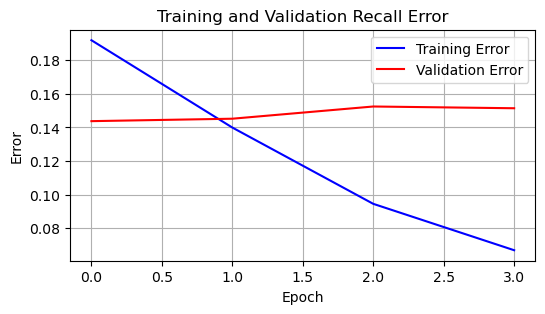

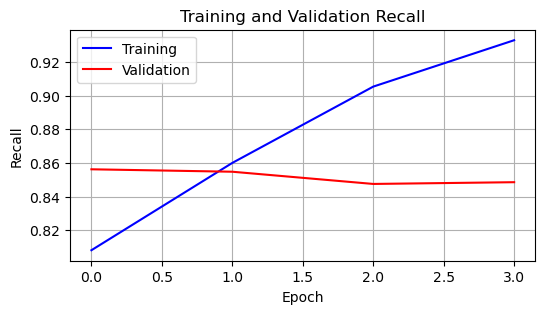

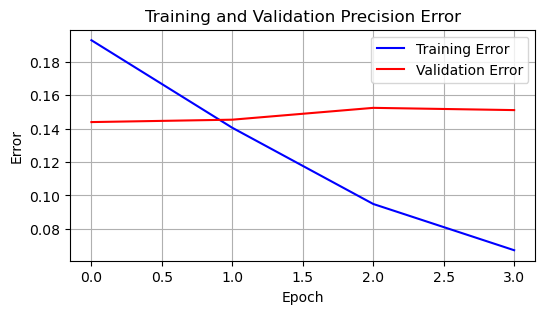

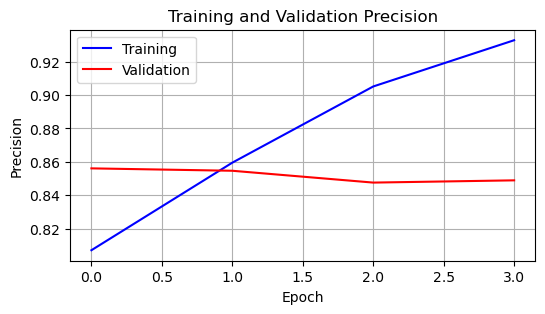

In [123]:
lambda_l1 = 0.08
lr = checkpoint['lr']
wd = checkpoint['wd']
print(f'lr: {lr}, wd: {wd}')
optimizer = optim.SGD(model.parameters(), lr=lr, momentum = 0.5, weight_decay=wd)
best_model = train_nn(model, train_nn_loader, val_loader, loss_fn, optimizer, 15, 3, folder_names, lambda_l1)
torch.save(best_model, 'best_model.pth')

# Final evaluation on the test set

In [124]:
cm, precision, recall, f1, val_time, loss = eval_model_test_set(best_model, test_loader, device, folder_names, loss_fn)
print(f'Test Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}, Time: {val_time // 60:.0f} minutes {val_time % 60:.2f} seconds')

Test Precision: 0.85, Recall: 0.85, F1 Score: 0.85, Time: 2 minutes 17.13 seconds


# Classify function


In [158]:
import PIL.Image as Image
from IPython.display import display

def classify(model, image_transforms, image_path, classes):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = image_transforms(image).float()
    image = image.unsqueeze(0)  
    device = next(model.parameters()).device
    image = image.to(device)
    
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs.data, 1)
        predicted_index = predicted.item()
        predicted_class = classes[predicted_index]
    
    # Print the predicted class
    print(predicted_class)

In [159]:
classes = [
    '1-2', '3-5', '6-10', '11-14', '15-17',
    '18-22', '23-27', '28-33', '34-40', '41-50',
    '51-60', '61-70', '71-80', 'over80'
]

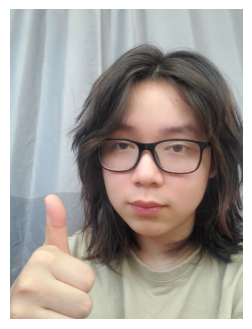

23-27


In [160]:

model = torch.load('best_model.pth')
im = Image.open('test.jpg')
rotated_image = im.transpose(Image.ROTATE_270)
plt.figure(figsize=(3, 5))
plt.imshow(rotated_image)
plt.axis('off')  
plt.show()
classify(best_model, transform, "test.jpg", classes)